# Failure Stresses

In [1]:
import collections
import copy
import functools
import unittest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import special
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp

from stat570 import datasets

failure_stresses = datasets.failure_stresses.load_data()
failure_stresses

,0,1,2,3,4,5,6,7,8,9,10,11,12
Length (mm),,,,,,,,,,,,,
1,2.247,2.640,2.842,2.908,3.099,3.126,3.245,3.328,3.355,3.383,3.572,3.581,3.681
10,1.901,2.132,2.203,2.228,2.257,2.350,2.361,2.396,2.397,2.445,2.454,2.454,2.474
20,1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006
50,1.339,1.434,1.549,1.574,1.589,1.613,1.746,1.753,1.764,1.807,1.812,1.840,1.852


## Model Specification

We specify priors for the scale, $\alpha \sim \operatorname{LogNormal}\left(\mu_\alpha, \sigma_\alpha\right)$, and the concentration (or shape), $\eta \sim \operatorname{LogNormal}\left(\mu_\eta, \sigma_\eta\right)$ for Weibull distribution: $Y \sim \operatorname{Weibull}\left(\alpha,\eta\right)$.

In [2]:
class WeibullModel:
    def __init__(self,
                 prior_alpha_mean, prior_alpha_standard_deviation,
                 prior_eta_mean, prior_eta_standard_deviation) -> None:
        self._prior_alpha_mean = prior_alpha_mean
        self._prior_alpha_standard_deviation = prior_alpha_standard_deviation
        self._prior_eta_mean = prior_eta_mean
        self._prior_eta_standard_deviation = prior_eta_standard_deviation
    
    def __call__(self, shape=()):
        alpha = tfp.edward2.as_random_variable(tfp.distributions.LogNormal(
            loc=self._prior_alpha_mean,
            scale=self._prior_alpha_standard_deviation,
            name='alpha'))
        
        eta = tfp.edward2.as_random_variable(tfp.distributions.LogNormal(
            loc=self._prior_eta_mean,
            scale=self._prior_eta_standard_deviation,
            name='eta'))
        
        return tfp.edward2.as_random_variable(tfp.distributions.TransformedDistribution(
            distribution=tfp.distributions.Uniform(high=1. + 1e-7),
            bijector=tfp.bijectors.Invert(
                tfp.bijectors.Weibull(scale=alpha, concentration=eta)),
            name='response'), sample_shape=shape)
    
    def make_log_joint_fn(self, labels):
        return functools.partial(
            tfp.edward2.make_log_joint_fn(lambda: self(tf.shape(labels))),
            response=labels)

## Inference

We construct a posterior over the model parameters and sample with MCMC to do inference on the parameters.

In [3]:
def model_fn(features, labels, mode, params, config):
    del features, config
    
    prior_alpha_mean = tf.convert_to_tensor(params['prior']['alpha']['mean'], tf.float32)
    prior_eta_mean = tf.convert_to_tensor(params['prior']['eta']['mean'], tf.float32)
    model = WeibullModel(
        prior_alpha_mean, tf.convert_to_tensor(params['prior']['alpha']['standard_deviation'], tf.float32),
        prior_eta_mean, tf.convert_to_tensor(params['prior']['eta']['standard_deviation'], tf.float32))
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return model().value
    
    log_joint_fn = model.make_log_joint_fn(labels)
    if mode == tf.estimator.ModeKeys.EVAL:
        return log_joint_fn(alpha=prior_alpha_mean, eta=prior_eta_mean)
    
    assert mode == tf.estimator.ModeKeys.TRAIN
        
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        num_leapfrog_steps=params['mcmc']['num_leapfrog_steps'],
        step_size=tf.get_variable('hmc_step_size_{}'.format(params['replica']),
                                  initializer=params['mcmc']['step_size'],
                                  use_resource=True, trainable=False),
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
        target_log_prob_fn=lambda alpha, eta: log_joint_fn(alpha=alpha, eta=eta),
        seed=params['mcmc']['seed'])
    
    states, _ = tfp.mcmc.sample_chain(
        kernel=kernel,  
        current_state=(
            tf.convert_to_tensor(params['mcmc']['initial_state']['alpha'], tf.float32),
            tf.convert_to_tensor(params['mcmc']['initial_state']['eta'], tf.float32)),
        num_results=params['mcmc']['num_results'],
        num_burnin_steps=params['mcmc']['num_burnin_steps'],
        num_steps_between_results=params['mcmc']['num_steps_between_results'],
        parallel_iterations=1)
    return states

## Choosing Prior Hyperparameters

In [4]:
def compute_log_norm_prior(l, u, density):
    """Computes the hyperparameters for lognormal distribution.
    
    Let X = exp(mu + sigma*Z). Computes mu and sigma such that
    P(l <= X <= u) = density.
    """
    tail_density = (1 - density)/2
    a, b = stats.norm.ppf(tail_density), stats.norm.ppf(1 - tail_density)    
    sigma = np.log(u/l)/(b - a)
    mu = np.log(u) - b*sigma
    return mu, sigma

class ComputeLogNormPrior(unittest.TestCase):    
    def test_compute_log_norm_prior(self):
        l, u = stats.uniform.rvs(0, 10), stats.uniform.rvs(20, 30)
        mu, sigma = compute_log_norm_prior(l, u, 0.9)
        self.assertAlmostEqual(
            stats.lognorm.cdf(l, scale=np.exp(mu), s=sigma), 0.05)
        self.assertAlmostEqual(
            stats.lognorm.sf(u, scale=np.exp(mu), s=sigma), 0.05)

unittest.main(argv=['_'], exit=False);

.
----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


We choose parameters with the values in the homework.

In [5]:
PARAMS = {
    'prior': {
        'eta': {'mean': 0., 'standard_deviation': 1.},
        'alpha': {'mean': 0., 'standard_deviation': 1.},
    },
    'mcmc': {
        'num_burnin_steps': 2**16,
        'num_leapfrog_steps': 5,
        'num_results': 2**15,
        'num_steps_between_results': 2,
        'step_size': 2e-2,
        'initial_state': {
            'alpha': 3.5,
            'eta': 9.,
        },
        'seed': 2018,
    },
    'replica': '0',
}

# Specify priors according to tail probabilities.
PARAMS['prior']['alpha']['mean'], PARAMS['prior']['alpha']['standard_deviation'] = (
    compute_log_norm_prior(1., 4., 0.9))
PARAMS['prior']['eta']['mean'], PARAMS['prior']['eta']['standard_deviation'] = (
    compute_log_norm_prior(1./2., 30., 0.9))
# Generate an initial state from the priors.
np.random.seed(PARAMS['mcmc']['seed'])
PARAMS['mcmc']['initial_state']['alpha'] = stats.lognorm.rvs(
    scale=np.exp(PARAMS['prior']['alpha']['mean']),
    s=PARAMS['prior']['alpha']['standard_deviation'])
PARAMS['mcmc']['initial_state']['eta'] = stats.lognorm.rvs(
    scale=np.exp(PARAMS['prior']['eta']['mean']),
    s=PARAMS['prior']['eta']['standard_deviation'])

PARAMS

{'mcmc': {'initial_state': {'alpha': 1.7798272858229207,
   'eta': 7.990013271262216},
  'num_burnin_steps': 65536,
  'num_leapfrog_steps': 5,
  'num_results': 32768,
  'num_steps_between_results': 2,
  'seed': 2018,
  'step_size': 0.02},
 'prior': {'alpha': {'mean': 0.6931471805599454,
   'standard_deviation': 0.4214035639417993},
  'eta': {'mean': 1.3540251005511053,
   'standard_deviation': 1.2445923744018637}},
 'replica': '0'}

## Running the Chains

We create a chain for each row data and run the chains in parallel.

In [6]:
from tensorflow.python import debug as tf_debug

np.set_printoptions(suppress=True)

def get_params(replica):
    params = copy.deepcopy(PARAMS)
    params['replica'] = replica
    return params

graph = tf.Graph()
with graph.as_default():
    features = tf.placeholder(name='features', dtype=tf.float32, shape=(None))
    labels_dict = {
        idx: tf.constant(data.values.astype(np.float32))
        for idx, data in failure_stresses.iterrows()
    }
    chain_ops = {
        idx: model_fn(features, labels, tf.estimator.ModeKeys.TRAIN,
                      get_params('train_{}'.format(idx)), tf.estimator.RunConfig())
        for idx, labels in labels_dict.items()
    }
    init_op = tf.group(tf.global_variables_initializer())
graph.finalize()

with graph.as_default(), tf.Session() as sess:
    sess.run(init_op)
    states = sess.run(chain_ops)
states = pd.DataFrame(np.vstack(states.values()).T,
                      columns=pd.MultiIndex.from_product(
                          [states.keys(), ['$\\alpha$', '$\\eta$']],
                          names=['Length (mm)', 'Parameter']))

## MCMC Diagnostics

We examine the trace plots to see if we've reached proper mixing.

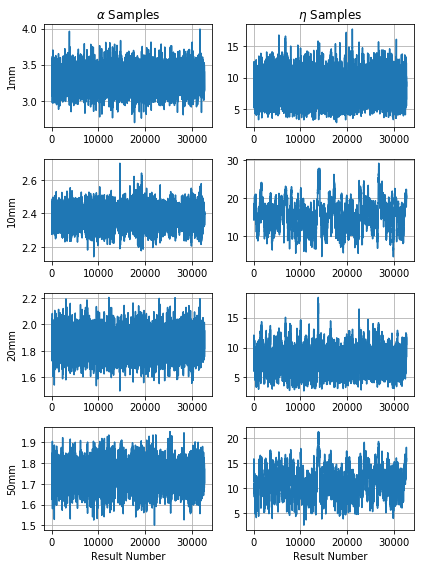

In [7]:
fig, axes = plt.subplots(
    figsize=(6,8), nrows=len(states.columns.levels[0]), ncols=len(states.columns.levels[1]))

for (_, samples), ax in zip(states.items(), np.hstack(axes)):
    ax.grid(True)
    ax.plot(samples)

for j, label in enumerate(states.columns.levels[1]):
    axes[0][j].set_title('{} Samples'.format(label))
    axes[-1][j].set_xlabel('Result Number')
    
for i, label in enumerate(states.columns.levels[0]):
    axes[i][0].set_ylabel('{}mm'.format(label))
    
fig.tight_layout()
fig.savefig('p2_trace.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

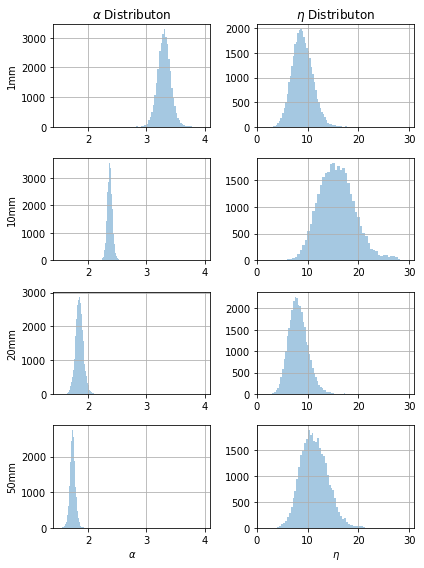

In [8]:
fig, axes = plt.subplots(nrows=len(states.columns.levels[0]),
                         ncols=len(states.columns.levels[1]),
                         figsize=(6,8))

for (idx, samples), ax in zip(states.items(), np.hstack(axes)):
    ax.grid(True)
    sns.distplot(samples.values, kde=False, ax=ax)
    if idx[1] == '$\\alpha$':
        ax.set_xlim(left=1.4, right=4.1)
    elif idx[1] == '$\\eta$':
        ax.set_xlim(left=0, right=31)

for j, label in enumerate(states.columns.levels[1]):
    axes[0][j].set_title('{} Distributon'.format(label))
    axes[-1][j].set_xlabel(label)
    
for i, label in enumerate(states.columns.levels[0]):
    axes[i][0].set_ylabel('{}mm'.format(label))
    
fig.tight_layout()
fig.savefig('p2_univariate.pdf', bbox_inches='tight')

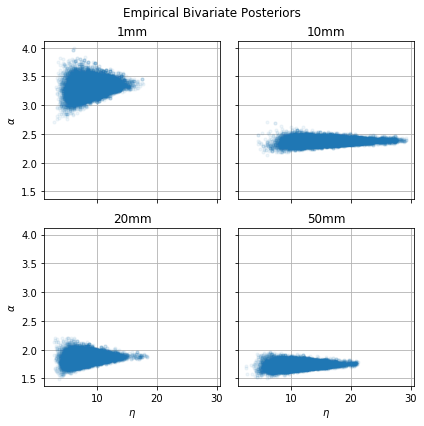

In [9]:
fig, axes = plt.subplots(
    figsize=(6,6), ncols=2, nrows=len(states.columns.levels[0])//2,
    sharex=True, sharey=True)
for length, ax in zip(states.columns.levels[0], np.hstack(axes)):
    ax.grid(True)
    ax.plot(states[length]['$\\eta$'], states[length]['$\\alpha$'], '.', alpha=1/16)
    ax.set_title('{}mm'.format(length))
for row in axes:
    row[0].set_ylabel('$\\alpha$')
for ax in axes[-1]:
    ax.set_xlabel('$\\eta$')
fig.tight_layout()
fig.suptitle('Empirical Bivariate Posteriors')
fig.subplots_adjust(top=0.9)
fig.savefig('p2_bivariate.pdf', bbox_inches='tight')

In [10]:
summaries = pd.DataFrame(collections.OrderedDict([
    ('Mean', states.mean()),
    ('Standard deviation', states.std(ddof=1)),
    ('Median', states.median()),
    ('5% quantile', states.quantile(0.05)),
    ('95% quantile', states.quantile(0.95))
]))
with open('p2_summary.tex', 'w') as f:
    f.write(summaries.to_latex(escape=False).replace('%', '\\%'))
summaries

Mean  Standard deviation     Median  5% quantile  \
Length (mm) Parameter                                                          
1           $\alpha$    3.304722            0.113267   3.303521     3.122608   
            $\eta$      8.945404            1.989280   8.837034     5.846150   
10          $\alpha$    2.369973            0.045122   2.369507     2.298008   
            $\eta$     15.779253            3.575655  15.611898    10.309790   
20          $\alpha$    1.849104            0.069687   1.847223     1.738584   
            $\eta$      8.176279            1.934859   8.019274     5.281827   
50          $\alpha$    1.732334            0.047075   1.731810     1.656464   
            $\eta$     11.302895            2.636021  11.133819     7.279310   

                       95% quantile  
Length (mm) Parameter                
1           $\alpha$       3.490909  
            $\eta$        12.363148  
10          $\alpha$       2.443862  
            $\eta$        21.820534  
20          $\alpha$       1.965827  
            $\eta$        11.535180  
50          $\alpha$       1.810707  
            $\eta$        15.768627